[intro and member names etc]

# Final/base HOG and SVM

Notes:     # c value and regularisation

## Setup

In [1]:
# Import required libraries

# I/O and file management
import os
import shutil
import joblib

# Numerical operations and data handling
import numpy as np
import pandas as pd

# For visualisation
from matplotlib import pyplot as plt

# Image processing and feature extraction
from PIL import Image
from skimage import color, io
from difflib import SequenceMatcher
import random
from skimage.feature import hog

# Custom hog function
import ablation_hog
import importlib
importlib.reload(ablation_hog)

# Model training and evaluation
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Defining image dimensions for HOG
IMG_WIDTH = 64
IMG_HEIGHT = 128

RAW_HUMAN_DIR = "data/raw/human"
RAW_NONHUMAN_DIR = "data/raw/nonhuman_cleaned" # Cleaned nonhuman images
# RAW_NONHUMAN_DIR = "data/raw/nonhuman"

PROCESSED_HUMAN_DIR = "data/processed/human"
PROCESSED_NONHUMAN_DIR = "data/processed/nonhuman"

IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")

In [2]:
processed_dir = os.path.join('data', 'processed')

# Delete the 'processed' folder if it exists
if os.path.exists(processed_dir):
    shutil.rmtree(processed_dir)
    print(f"Deleted folder: {processed_dir}")
else:
    print(f"No folder to delete at: {processed_dir}")

Deleted folder: data/processed


## Data processing

In [3]:
# Checking it can read the data
# from subprocess import check_output
# print(check_output(["ls", "data/raw/human"]).decode("utf8"))

In [4]:
# Directories
input_folder = "data/raw/human"
output_folder = "data/processed/human_deduplicated"
os.makedirs(output_folder, exist_ok=True)

def is_new_person(prev, curr, threshold=0.4):
    # Similarity ratio between the filenames (0 to 1)
    similarity = SequenceMatcher(None, prev, curr).ratio()
    
    # Change in length (as % of longer filename)
    len_change = abs(len(prev) - len(curr)) / max(len(prev), len(curr))

    # Consider a new person if similarity is low or length difference is high
    return similarity < (1 - threshold) or len_change > 0.4

filenames = sorted([
    f for f in os.listdir(input_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
])

# Group based on filename change
grouped = []
current_group = [filenames[0]]

for i in range(1, len(filenames)):
    if is_new_person(filenames[i - 1], filenames[i]):
        grouped.append(current_group)
        current_group = [filenames[i]]
    else:
        current_group.append(filenames[i])

grouped.append(current_group)  # Add the last group

# Print out group sizes
for idx, group in enumerate(grouped):
    print(f"Person {idx:03d} ({len(group)} images): {group}")

# Copy one image per group
for idx, group in enumerate(grouped):
    representative = group[0]
    src = os.path.join(input_folder, representative)
    dst = os.path.join(output_folder, representative)
    shutil.copy2(src, dst)

print(f"Deduplicated {len(filenames)} → {len(grouped)} images.")


Person 000 (19 images): ['00001_male_back.jpg', '00002_male_back.jpg', '00003_male_back.jpg', '00004_male_back.jpg', '00005_male_back.jpg', '00006_female_back.jpg', '00007_male_fore.jpg', '00008_male_fore.jpg', '00009_male_back.jpg', '00010_female_fore.jpg', '00011_male_fore.jpg', '00012_female_fore.jpg', '00013_male_back.jpg', '00014_female_fore.jpg', '00015_female_fore.jpg', '00016_male_fore.jpg', '00017_female_fore.jpg', '00018_male_fore.jpg', '00019_male_fore.jpg']
Person 001 (10 images): ['0001_001.jpg', '0001_002.jpg', '0001_003.jpg', '0001_004.jpg', '0001_005.jpg', '0001_006.jpg', '0001_007.jpg', '0001_008.jpg', '0001_009.jpg', '0001_010.jpg']
Person 002 (2 images): ['0001_1_25004_107_32_106_221.jpeg', '0001_2_25023_116_134_128_330.jpeg']
Person 003 (3 images): ['0001_a.png', '0001_b.png', '0002.png']
Person 004 (10 images): ['00020_female_fore.jpg', '00021_male_fore.jpg', '00022_male_fore.jpg', '00023_female_back.jpg', '00024_female_fore.jpg', '00025_female_fore.jpg', '00026_fe

### Resizing and centre cropping human image examples

`resize_and_center_crop` starts with ~18000 images and ends with ~12000 images.

`resize_with_padding` starts with ~18000 images and does not discard any images.


In [5]:
# input_folder = RAW_HUMAN_DIR
input_folder = "data/processed/human_deduplicated"
output_folder = "data/processed/human_resized"
os.makedirs(output_folder, exist_ok=True)

human_records = []

def resize_with_padding(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT, fill_color=(0, 0, 0)):
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    # Resize while keeping aspect ratio (fit inside target box)
    if img_ratio > target_ratio:
        # Image is wider than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)
    else:
        # Image is taller or narrower than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Create new image and paste the resized on center
    new_img = Image.new("RGB", (target_width, target_height), fill_color)
    left = (target_width - new_width) // 2
    top = (target_height - new_height) // 2
    new_img.paste(img_resized, (left, top))

    return new_img

def resize_and_center_crop(img, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    # Resize while keeping aspect ratio, but ensure the image is at least target size in both dimensions
    img_ratio = img.width / img.height
    target_ratio = target_width / target_height

    if img_ratio > target_ratio:
        # Image is wider than target — resize based on height
        new_height = target_height
        new_width = int(target_height * img_ratio)
    else:
        # Image is taller or narrower than target — resize based on width
        new_width = target_width
        new_height = int(target_width / img_ratio)

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)

    # Center crop to target size
    left = (img_resized.width - target_width) // 2
    top = (img_resized.height - target_height) // 2
    right = left + target_width
    bottom = top + target_height

    return img_resized.crop((left, top, right, bottom))

for filename in os.listdir(input_folder):
    if filename.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, filename)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        cropped = resize_with_padding(img)
        cropped.save(os.path.join(output_folder, filename))

        human_records.append({
            "crop_filename": filename,
            "original_filename": filename,  # assuming all unique
            "crop_image": cropped
        })

### Downscaling and obtaining non-overlapping crops of nonhuman images

Starts with 1218 nonhuman images and ends with ~13000 unique nonhuman images.

In [6]:
input_folder = RAW_NONHUMAN_DIR
output_folder = PROCESSED_NONHUMAN_DIR
SAMPLE_SIZE = 3562 # Set to be size of human dataset
os.makedirs(output_folder, exist_ok=True)

crop_records = [] # Stores the origin image
crop_id = 0  # Unique filename ID
scale_factor = 11 / 20  # Downsize images before cropping

for fname in os.listdir(input_folder):
    # if fname.lower().endswith((IMAGE_EXTENSIONS)) and crop_id < 3561:
    if fname.lower().endswith((IMAGE_EXTENSIONS)):
        path = os.path.join(input_folder, fname)
        img = Image.open(path)
        # img = Image.open(path).convert("RGB")
        # width, height = img.size

        # Resize image to */* of original size
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img_resized = img.resize((new_width, new_height), Image.LANCZOS)

        # Calculate number of non-overlapping crops that fit
        num_x = new_width // IMG_WIDTH
        num_y = new_height // IMG_HEIGHT

        for y in range(num_y):
            for x in range(num_x):
                left = x * IMG_WIDTH
                top = y * IMG_HEIGHT
                right = left + IMG_WIDTH
                bottom = top + IMG_HEIGHT

                crop = img_resized.crop((left, top, right, bottom))
                crop_filename = f"nonhuman_{crop_id}.jpg"

                crop_records.append({
                    "crop_id": crop_id,
                    "crop_filename": crop_filename,
                    "original_filename": fname,
                    "crop_image": crop
                })

                crop_id += 1

print(f"Generated {len(crop_records)} crops from raw images.")

# Randomly select a subset
selected_records = random.sample(crop_records, SAMPLE_SIZE)

# Save the selected crops and record metadata
nonhuman_records = []
for record in selected_records:
    out_path = os.path.join(output_folder, record["crop_filename"])
    record["crop_image"].save(out_path)
    nonhuman_records.append({
        "crop_filename": record["crop_filename"],
        "original_filename": record["original_filename"],
        "crop_image": record["crop_image"]
    })

print(f"Subsampled and saved {SAMPLE_SIZE} crops to {output_folder}")

Generated 5068 crops from raw images.
Subsampled and saved 3562 crops to data/processed/nonhuman


## HOG and SVM training and evaluation

In [7]:
# from ablation_hog import custom_hog

# Best parameters for HOG
ORIENTATIONS = 12
PIXELS_PER_CELL = (8, 8)
CELLS_PER_BLOCK = (2, 2)
BLOCK_NORM = 'L2-Hys'
FEATURE_VECTOR = True

# For custom HOG only
GRADIENT = 'scharr'
GAMMA=1.0
GAUSSIAN_SIGMA=0.0

In [8]:
image_size = (IMG_WIDTH, IMG_HEIGHT)

# def extract_hog_features(img_path, orientations, pixels_per_cell, block_norm, feature_vector,
#                         gradient, gamma, gaussian_sigma):
#     img = Image.open(img_path).convert("L").resize(image_size)
#     img_np = np.array(img)
    
#     hog_features = custom_hog(img_np, orientations=orientations, pixels_per_cell=pixels_per_cell,
#                             block_norm=block_norm, transform_sqrt=True,
#                             feature_vector=feature_vector, unsigned=True, gradient=gradient,
#                             gamma=gamma, gaussian_sigma=gaussian_sigma)

#     return hog_features

def extract_hog(human_records, nonhuman_records, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector):
    hog_data = []
    # features = []
    # labels = []
    
    # Process human images (label = 1)
    for record in human_records:
        img = record["crop_image"].convert("L").resize(image_size)
        img_np = np.array(img)
        hog_feature, hog_image = hog(img_np,
                            orientations=orientations,
                            pixels_per_cell=pixels_per_cell,
                            cells_per_block=cells_per_block,
                            block_norm=block_norm,
                            feature_vector=feature_vector,
                            visualize=True
                            )
        hog_data.append({
            "features": hog_feature,
            "label": 1,
            "orig_image": record["crop_image"],
            "hog_image": hog_image,
            "filename": record["crop_filename"],
            "group": record["crop_filename"]  # unique per image
        })

    # Process nonhuman images (label = 0)
    for record in nonhuman_records:
        img = record["crop_image"].convert("L").resize(image_size)
        img_np = np.array(img)
        hog_feature, hog_image = hog(
            img_np,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm=block_norm,
            feature_vector=feature_vector,
            visualize=True
        )
        hog_data.append({
            "features": hog_feature,
            "label": 0,
            "orig_image": record["crop_image"],
            "hog_image": hog_image,
            "filename": record["crop_filename"],
            "group": record["original_filename"]  # group by original image
        })
    
    return hog_data

def split_data(hog_data, test_size=0.2, random_state=42):
    features = [item["features"] for item in hog_data]
    labels = [item["label"] for item in hog_data]
    groups = [item["group"] for item in hog_data]  # same original image → same group

    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(features, labels, groups))

    X_train = [features[i] for i in train_idx]
    y_train = [labels[i] for i in train_idx]
    X_test = [features[i] for i in test_idx]
    y_test = [labels[i] for i in test_idx]
    
    return X_train, X_test, y_train, y_test

In [9]:
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    miss_rate = 1 - recall
    # fppw = fp / len(y_true)  # False positives per window

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Miss Rate": miss_rate,
        # "FPPW": fppw
        "False Positives": fp,
        "False Positive Rate": fp / (fp + tn)
    }

def evaluate_thresholds(y_true, decision_scores, thresholds):
    results = []
    for thresh in thresholds:
        y_pred_thresh = (decision_scores >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        results.append({
            'threshold': thresh,
            'FPR': fpr,
            'FNR': fnr,
        })
    return results

def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    # Fit the model
    clf = LinearSVC(random_state=42)
    clf.fit(X_train, y_train)

    # Predict on train set
    y_train_pred = clf.predict(X_train)

    # Predict on test set
    y_test_pred = clf.predict(X_test)

    # Compute metrics
    train_metrics = compute_metrics(y_train, y_train_pred)
    test_metrics = compute_metrics(y_test, y_test_pred)

    # Get decision scores on test set
    decision_scores = clf.decision_function(X_test)

    # Define thresholds to sweep — e.g., between min and max scores
    thresholds = np.linspace(decision_scores.min(), decision_scores.max(), 100)

    # Evaluate FPR and FNR at each threshold
    threshold_results = evaluate_thresholds(y_test, decision_scores, thresholds)

    return clf, train_metrics, test_metrics, threshold_results

In [10]:
def full_pipeline(human_records, nonhuman_records, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector):
    hog_data = extract_hog(human_records, nonhuman_records, orientations, pixels_per_cell, cells_per_block, block_norm, feature_vector)
    X_train, X_test, y_train, y_test = split_data(hog_data)
    clf, train_metrics, test_metrics, threshold_results = train_and_evaluate_model(X_train, y_train, X_test, y_test)
    return clf, train_metrics, test_metrics, threshold_results

# Run the full pipeline on the best parameters
clf, train_metrics, test_metrics, threshold_results = full_pipeline(
    human_records=human_records,
    nonhuman_records=nonhuman_records,
    orientations=ORIENTATIONS,
    pixels_per_cell=PIXELS_PER_CELL,
    cells_per_block=CELLS_PER_BLOCK,
    block_norm=BLOCK_NORM,
    feature_vector=FEATURE_VECTOR,
)

# Combine into a DataFrame
df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

# Display nicely
print("Evaluation Metrics:")
display(df.round(4))

Evaluation Metrics:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.000,1.0000,0.000,0,0.0000
Test Set,0.9662,0.9635,0.962,0.9627,0.038,25,0.0303


In [11]:
hog_data = extract_hog(human_records=human_records,
    nonhuman_records=nonhuman_records,
    orientations=ORIENTATIONS,
    pixels_per_cell=PIXELS_PER_CELL,
    cells_per_block=CELLS_PER_BLOCK,
    block_norm=BLOCK_NORM,
    feature_vector=FEATURE_VECTOR)

X_train, X_test, y_train, y_test = split_data(hog_data)

# Optimise SVM parameters for further performance improvement
print("Running GridSearchCV to find best C...")
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
svc = LinearSVC(max_iter=10000, random_state=42)
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', refit=True, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
optimised_clf = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Predict on train set
y_train_pred = optimised_clf.predict(X_train)

# Predict on test set
y_test_pred = optimised_clf.predict(X_test)

# Compute metrics
train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

# Get decision scores on test set
decision_scores = optimised_clf.decision_function(X_test)

# Define thresholds to sweep — e.g., between min and max scores
thresholds = np.linspace(decision_scores.min(), decision_scores.max(), 100)

# Evaluate FPR and FNR at each threshold
threshold_results = evaluate_thresholds(y_test, decision_scores, thresholds)

# Combine into a DataFrame
df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

# Display nicely
print("Evaluation Metrics:")
display(df.round(4))

Running GridSearchCV to find best C...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/miniconda3/envs/cits4402-computer-vision/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found: {'C': 0.01}
Best cross-validation score: 0.9690
Evaluation Metrics:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9925,0.9955,0.9899,0.9927,0.0101,13,0.0047
Test Set,0.9728,0.9721,0.9679,0.9700,0.0321,19,0.0231


In [12]:
joblib.dump(optimised_clf, '../Test_Examples/svm_model.pkl')

['../Test_Examples/svm_model.pkl']

# Ablation studies

## Study 1: Effect of number of orientation bins on miss rate and false positives

In [13]:
orientations = [6, 8, 9, 12, 18]
orientation_metrics = []
orientation_threshold_results = []

for orientation in orientations:
    clf, train_metrics, test_metrics, threshold_results = full_pipeline(
        human_records=human_records,
        nonhuman_records=nonhuman_records,
        orientations=orientation,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=BLOCK_NORM,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for orientation {orientation}:")
    display(df.round(4))

    orientation_metrics.append((train_metrics, test_metrics))
    orientation_threshold_results.append(threshold_results)

Evaluation Metrics for orientation 6:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9629,0.9605,0.9577,0.9591,0.0423,27,0.0328


Evaluation Metrics for orientation 8:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9689,0.9705,0.9606,0.9655,0.0394,20,0.0243


Evaluation Metrics for orientation 9:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.000,1.0000,0.000,0,0.0000
Test Set,0.9689,0.9664,0.965,0.9657,0.035,23,0.0279


Evaluation Metrics for orientation 12:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.000,1.0000,0.000,0,0.0000
Test Set,0.9662,0.9635,0.962,0.9627,0.038,25,0.0303


Evaluation Metrics for orientation 18:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9669,0.9662,0.9606,0.9634,0.0394,23,0.0279


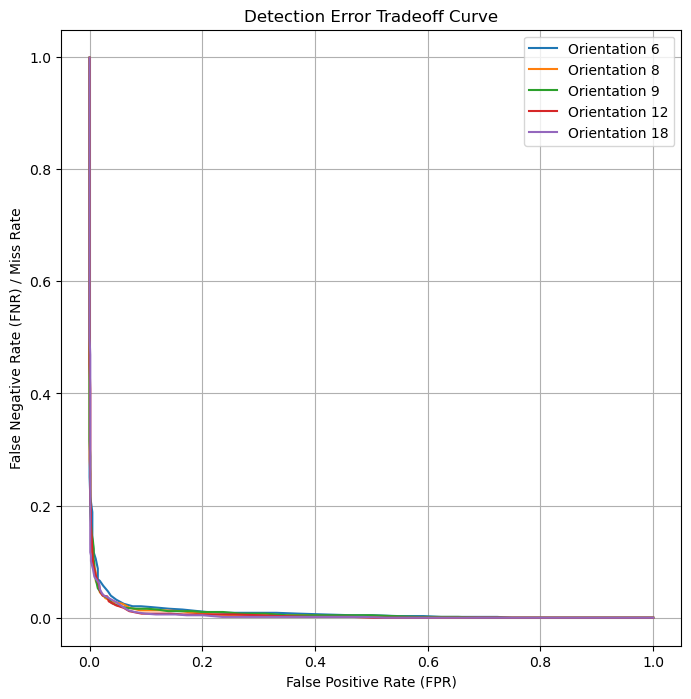

In [14]:
plt.figure(figsize=(8, 8))

for orientation, results in enumerate(orientation_threshold_results):
    fpr = [r['FPR'] for r in results]
    fnr = [r['FNR'] for r in results]
    plt.plot(fpr, fnr, label=f"Orientation {orientations[orientation]}")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("False Negative Rate (FNR) / Miss Rate")
plt.title("Detection Error Tradeoff Curve")
plt.grid(True)
plt.legend()
plt.show()


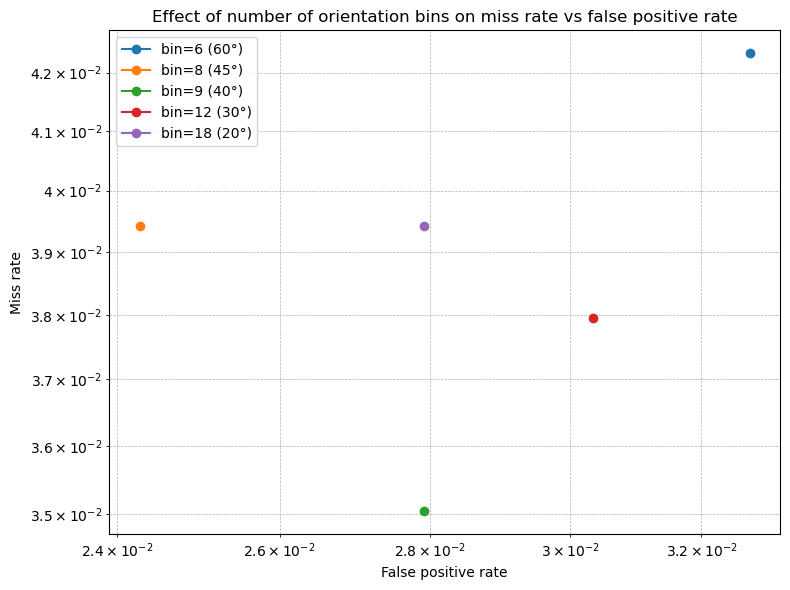

In [15]:
orientation_test_miss_rates = [test["Miss Rate"] for _, test in orientation_metrics]
orientation_test_fpr = [test["False Positive Rate"] for _, test in orientation_metrics]

# # Plot Miss Rate vs Orientation Bins
# plt.figure(figsize=(10, 5))
# plt.plot(orientations, orientation_test_miss_rates, marker='o', label='Miss Rate')
# plt.title('Miss Rate vs Number of Orientation Bins')
# plt.xlabel('Number of Orientation Bins')
# plt.ylabel('Miss Rate')
# plt.grid(True)
# plt.legend()
# plt.show()

plt.figure(figsize=(8, 6))

for i, orient in enumerate(orientations):
    fp = orientation_test_fpr[i]  # list of false positives per window
    mr = orientation_test_miss_rates[i]       # list of miss rates
    plt.plot(fp, mr, marker='o', label=f'bin={orient} ({360 // orient}°)')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("False positive rate")
plt.ylabel("Miss rate")
plt.title("Effect of number of orientation bins on miss rate vs false positive rate")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Study 2: Effect of block size on miss rate and false positives

In [16]:
block_sizes = [(8, 8), (16, 16), (24, 24), (32, 32)]
block_size_metrics = []
block_size_threshold_results = []

for block_size in block_sizes:
    clf, train_metrics, test_metrics, threshold_results = full_pipeline(
        human_records=human_records,
        nonhuman_records=nonhuman_records,
        orientations=ORIENTATIONS,
        pixels_per_cell=block_size,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=BLOCK_NORM,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for block size {block_size}:")
    display(df.round(4))

    block_size_metrics.append((train_metrics, test_metrics))
    block_size_threshold_results.append(threshold_results)

Evaluation Metrics for block size (8, 8):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.000,1.0000,0.000,0,0.0000
Test Set,0.9662,0.9635,0.962,0.9627,0.038,25,0.0303


Evaluation Metrics for block size (16, 16):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9906,0.9923,0.9892,0.9908,0.0108,22,0.0080
Test Set,0.9682,0.9623,0.9679,0.9651,0.0321,26,0.0316


Evaluation Metrics for block size (24, 24):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9434,0.9438,0.9458,0.9448,0.0542,162,0.0592
Test Set,0.9317,0.9242,0.9255,0.9249,0.0745,52,0.0631


Evaluation Metrics for block size (32, 32):


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9307,0.9293,0.9360,0.9326,0.0640,205,0.0749
Test Set,0.9291,0.9188,0.9255,0.9222,0.0745,56,0.0680


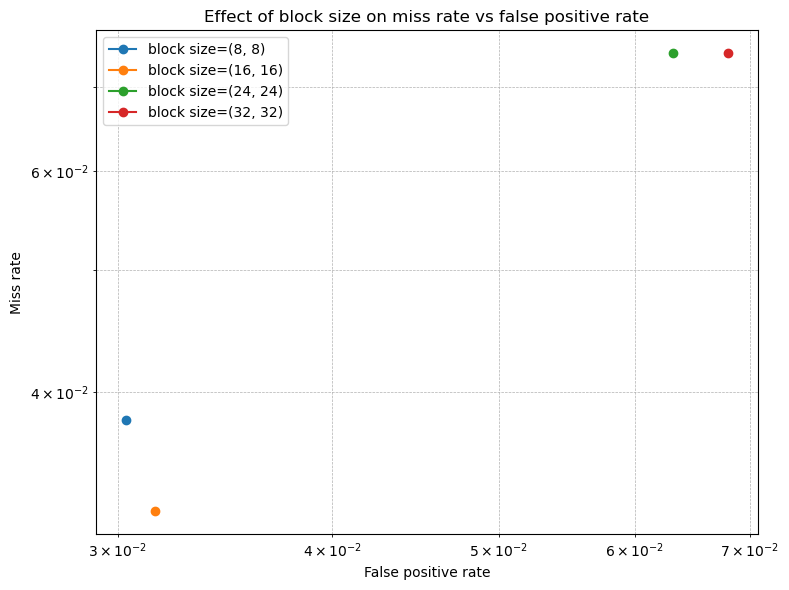

In [17]:
block_size_test_miss_rates = [test["Miss Rate"] for _, test in block_size_metrics]
block_size_test_fpr = [test["False Positive Rate"] for _, test in block_size_metrics]

plt.figure(figsize=(8, 6))

for i, block_size in enumerate(block_sizes):
    fp = block_size_test_fpr[i]  # list of false positives per window
    mr = block_size_test_miss_rates[i]       # list of miss rates
    plt.plot(fp, mr, marker='o', label=f'block size={block_size}')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("False positive rate")
plt.ylabel("Miss rate")
plt.title("Effect of block size on miss rate vs false positive rate")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Study 3: Effect of normalisation technique on miss rate and false positives

In [18]:
norm_techniques = ['L1', 'L1-sqrt', 'L2', 'L2-Hys']
norm_technique_metrics = []
norm_technique_threshold_results = []

for norm_technique in norm_techniques:
    clf, train_metrics, test_metrics, threshold_results = full_pipeline(
        human_records=human_records,
        nonhuman_records=nonhuman_records,
        orientations=ORIENTATIONS,
        pixels_per_cell=PIXELS_PER_CELL,
        cells_per_block=CELLS_PER_BLOCK,
        block_norm=norm_technique,
        feature_vector=FEATURE_VECTOR,
    )

    # Combine into a DataFrame
    df = pd.DataFrame([train_metrics, test_metrics], index=["Train Set", "Test Set"])

    # Display nicely
    print(f"Evaluation Metrics for normalisation technique {norm_technique}:")
    display(df.round(4))

    norm_technique_metrics.append((train_metrics, test_metrics))
    norm_technique_threshold_results.append(threshold_results)

Evaluation Metrics for normalisation technique L1:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,0.9998,1.0000,0.9997,0.9998,0.0003,0,0.0000
Test Set,0.9708,0.9693,0.9664,0.9678,0.0336,21,0.0255


Evaluation Metrics for normalisation technique L1-sqrt:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9715,0.9679,0.9693,0.9686,0.0307,22,0.0267


Evaluation Metrics for normalisation technique L2:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.0000,1.0000,0.0000,0,0.0000
Test Set,0.9669,0.9635,0.9635,0.9635,0.0365,25,0.0303


Evaluation Metrics for normalisation technique L2-Hys:


,Accuracy,Precision,Recall,F1 Score,Miss Rate,False Positives,False Positive Rate
Train Set,1.0000,1.0000,1.000,1.0000,0.000,0,0.0000
Test Set,0.9662,0.9635,0.962,0.9627,0.038,25,0.0303


/var/folders/ls/k45qwb0x1rz7pnltp8tzmc2w0000gn/T/ipykernel_37623/1687805299.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


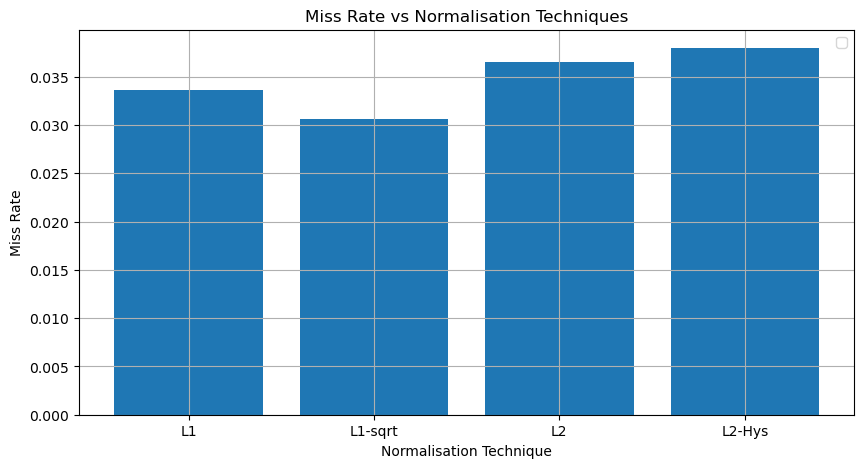

In [19]:
norm_technique_test_miss_rates = [test["Miss Rate"] for _, test in norm_technique_metrics]

# Plot Miss Rate vs Normalisation Techniques
plt.figure(figsize=(10, 5))
plt.bar(norm_techniques, norm_technique_test_miss_rates)
plt.title('Miss Rate vs Normalisation Techniques')
plt.xlabel('Normalisation Technique')
plt.ylabel('Miss Rate')
plt.grid(True)
plt.legend()
plt.show()

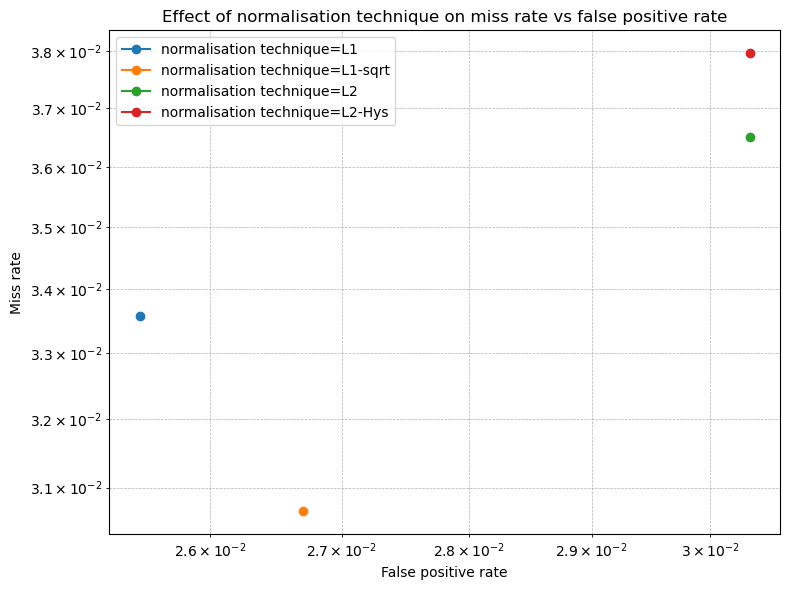

In [20]:
norm_technique_test_miss_rates = [test["Miss Rate"] for _, test in norm_technique_metrics]
norm_technique_test_fpr = [test["False Positive Rate"] for _, test in norm_technique_metrics]

plt.figure(figsize=(8, 6))

for i, norm_technique in enumerate(norm_techniques):
    fp = norm_technique_test_fpr[i]  # list of false positives per window
    mr = norm_technique_test_miss_rates[i]       # list of miss rates
    plt.plot(fp, mr, marker='o', label=f'normalisation technique={norm_technique}')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("False positive rate")
plt.ylabel("Miss rate")
plt.title("Effect of normalisation technique on miss rate vs false positive rate")
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Visualisation of HOG and other debugging (might be useful later)

In [21]:
from skimage import data, exposure

# img = Image.open(img_path).convert("L").resize(image_size)


def extract_hog_features(img_path):
    img = Image.open(img_path).convert("L").resize(image_size)
    img_np = np.array(img)
    hog_features, hog_image = hog(
        img_np,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        feature_vector=True,
        visualize=True,
        # channel_axis=-1,
    )
    return hog_features, hog_image

print(labels[-1])
hog_features, hog_image = extract_hog_features('data/processed/human/0_8.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

print(hog_features)

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

NameError: name 'labels' is not defined

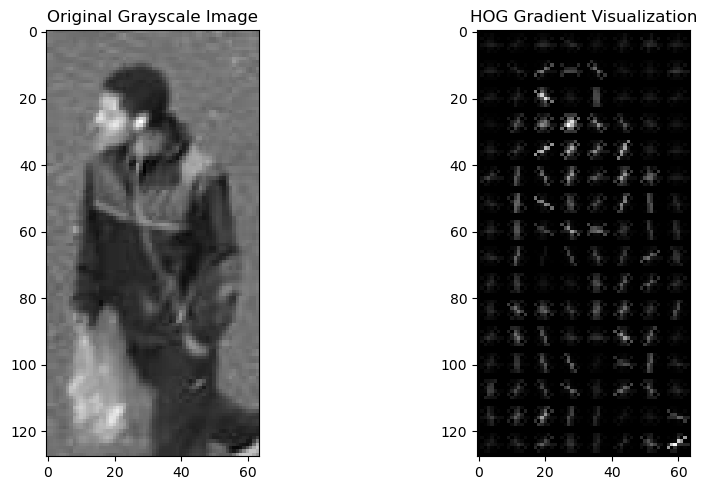

In [ ]:
# Load and convert image to grayscale
image = io.imread("data/processed/human/0_8.jpg")  # replace with your path
gray_image = color.rgb2gray(image)

# Compute HOG features and visualization
features, hog_image = hog(
    gray_image,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    block_norm='L2-Hys'
)

# Plot original and HOG gradient image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Original Grayscale Image")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Gradient Visualization")

plt.tight_layout()
plt.show()